In [33]:
# ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# import basic tools
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Part1: Linear Regression

## Prepare Data

In [151]:
# Crate random linear data
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)
m = 100

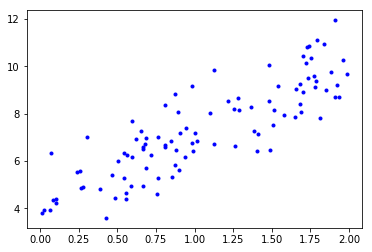

In [152]:
# plot random data
plt.plot(X, y, 'b.')
plt.show()

## The Normal Equation

In [153]:
# Calculate theta by normal equation
X_b = np.c_[np.ones((100, 1)), X] # add x0 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.23060927],
       [2.90659784]])

In [154]:
# make prediction
X_new = np.array([[0], [2]])            # X轴最左边和最右边的值
X_new_b = np.c_[np.ones((2, 1)), X_new] # 为了预测添加Theta0
y_predict = X_new_b.dot(theta_best)     # 2x2 * 2x1
y_predict

array([[ 4.23060927],
       [10.04380495]])

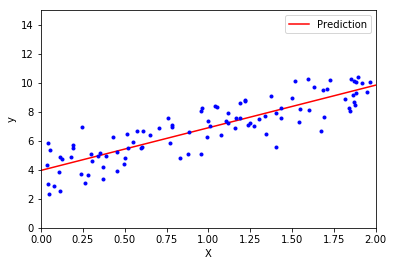

In [51]:
# plot prediction
plt.plot(X_new, y_predict, 'r-', label='Prediction')
plt.plot(X, y, 'b.')
plt.axis([0, 2, 0, 15])
plt.xlabel('X')
plt.ylabel('y')
# plt.show()
plt.legend() # 为了显示图例label使用

In [155]:
# Using LinearRegression in sklearn
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.predict(X_new)

array([[ 4.23060927],
       [10.04380495]])

#### Note: Computational Complexity

The computational complexity of inverting such a matrix is typically about O(n2.4) to O(n3) (depending on the implementation). 

The Normal Equation gets very slow when the number of features grows large (e.g., 100,000).

## Batch Gradient Descent

In [164]:
eta = 0.1 # learning rate
n_iterations = 1000

theta = np.random.randn(2, 1) # random initialization
bgd_hypothesis = []
for iteration in range(n_iterations):
    # 计算Gradient，这里每次会对所有X数据进行处理，因此在训练数据很多的情况下，
    # 效率比较差(Batch Gradient Descent)，但可以同时进行很多feature的计算，这点上比Normal Equation要好
    gradients = 2 / m * X_b.T.dot(X_b.dot(theta) - y) 
    theta = theta - eta * gradients
    # 采集递减过程的数据，用于展示图形
    std_error = sum(2 / m * np.sqrt(np.power(X_b.dot(theta) - y, 2)))
    bgd_hypothesis.append(std_error)
print("theta:\n", theta)
print("predict:\n", X_new_b.dot(theta))

theta:
 [[4.23060927]
 [2.90659784]]
predict:
 [[ 4.23060927]
 [10.04380495]]


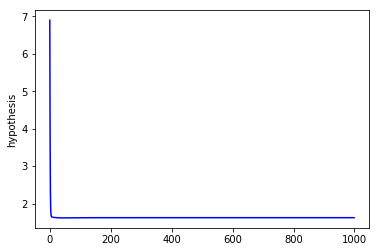

In [165]:
# 这里的学习曲线下降非常快导致看起来像一条直线...
plt.plot(range(n_iterations), bgd_hypothesis, 'b-')
plt.ylabel("hypothesis")
plt.show()

## Stochastic Gradient Descent

Stochastic Gradient Descent just picks a random instance in the training set at every step and computes the gradients based only on that single instance.

In [189]:
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparamaters

def learning_schedule(t): # learning rate 逐步递减, 基数为 5/50
    return t0 / (t + t1)

theta = np.random.randn(2, 1) # random initialization

sgd_hypothesis = []
for epoch in range(n_epochs):
    # 采集递减过程的数据，用于展示图形
    std_error = sum(2 / m * np.sqrt(np.power(X_b.dot(theta) - y, 2)))
    sgd_hypothesis.append(std_error)
    
    # 每轮遍历会逐步扩大随机取值范围直到所有训练数据
    for i in range(m):
        # 随机取一组相邻数值计算Gradient
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

print("theta:\n", theta)
print("predict:\n", X_new_b.dot(theta))

theta:
 [[4.25658262]
 [2.93373574]]
predict:
 [[ 4.25658262]
 [10.1240541 ]]


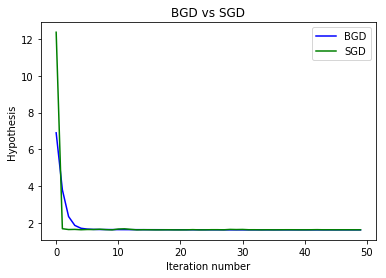

In [192]:
plt.plot(range(n_epochs), bgd_hypothesis[:n_epochs], 'b-', label='BGD')
plt.plot(range(n_epochs), sgd_hypothesis, 'g-', label='SGD')
plt.title('BGD vs SGD')
plt.ylabel('Hypothesis')
plt.xlabel('Iteration number')
plt.legend()

### BGD & SGD 在相近效果下的对比
Batch Gradient Descent 遍历1000遍，每轮遍历需要计算所有100个训练数据

Stochastic Gradient Descent 只需遍历50遍，每轮遍历所随机取100个训练数据

In [197]:
# Using SGD in sklearn
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=50, penalty=None, eta0=0.1)
sgd_reg.fit(X_b, y.ravel()) # y.ravel()降维作用
sgd_reg.predict(X_new_b)

array([ 4.26336051, 10.13321942])

## Mini-batch Gradient Descent

Mini-batch Gradient Descent结合了BGD和SGD的特性，每轮遍历随机选取一小组数据进行Gradient计算

我们可以通过矩阵来进行多个数据的计算，这种矩阵计算可以利用硬件进行加速

In [235]:
mini_batch_size = 10

theta = np.random.randn(2, 1) # random initialization
mgd_hypothesis = []

for epoch in range(n_epochs):
    # 采集递减过程的数据，用于展示图形
    std_error = sum(2 / m * np.sqrt(np.power(X_b.dot(theta) - y, 2)))
    mgd_hypothesis.append(std_error)
    
    # 每轮遍历会逐步扩大随机取值范围直到所有训练数据
    for i in range(m):
        # 随机取一组相邻数值计算Gradient
        batch_count = min(max(i, 2), mini_batch_size)
        random_indices = np.random.permutation(m)[:batch_count]
        Xi = X_b[random_indices]
        yi = y[random_indices]
        gradients = 2 / batch_count * Xi.T.dot(Xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
    
print("theta:\n", theta)
print("predict:\n", X_new_b.dot(theta))

theta:
 [[4.22523626]
 [2.90066867]]
predict:
 [[ 4.22523626]
 [10.02657361]]


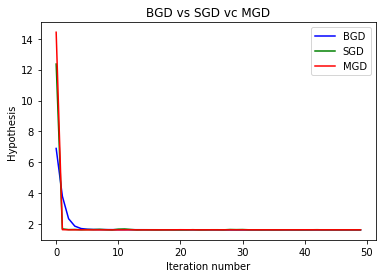

In [238]:
plt.plot(range(n_epochs), bgd_hypothesis[:n_epochs], 'b-', label='BGD')
plt.plot(range(n_epochs), sgd_hypothesis, 'g-', label='SGD')
plt.plot(range(n_epochs), mgd_hypothesis, 'r-', label='MGD')
plt.title('BGD vs SGD vc MGD')
plt.ylabel('Hypothesis')
plt.xlabel('Iteration number')
plt.legend()

Mini-batch的递减曲线与SGD相近，但会比SGD更快接近最优值，同时最后的波动会比SGD小